<a href="https://colab.research.google.com/github/tugcegurbuz/DeepLearning_TF/blob/master/DL_TF_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description:** In this lab we will deal with logistic regression with TensorFlow

Example dataset: Iris

Prepared by Tugce Gurbuz

Reference: https://labs.cognitiveclass.ai/tools/jupyterlab/lab/tree/labs/ML0120EN/ML0120EN-1.4-Review-LogisticRegressionwithTensorFlow.ipynb

---

Despite the name logistic <i>regression</i>, it is actually a <b>probabilistic classification</b> model. Logistic regression fits a special s-shaped curve by taking the linear regression and transforming the numeric estimate into a probability with the following function:

$$
ProbabilityOfaClass = \theta(y) = \frac{e^y}{1 + e^y} = exp(y) / (1 + exp(y)) = p 
$$


In [0]:
#Import required libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [0]:
#Load the iris data
iris = load_iris()

#Get IVs and DVs from the dataset
iris_X, iris_y = iris.data[:-1,:], iris.target[:-1]

#Convert categorical DV into dummy/indicator variables
iris_y= pd.get_dummies(iris_y).values

#Train X and Y by splitting the data into 2 pieces(e.g., test and training data)
#by 0.33 proportion
trainX, testX, trainY, testY = train_test_split(iris_X, iris_y, test_size=0.33, 
                                                random_state=42)

Now,  we will have placeholders to hold our iris data and pass these data to different parts of our algorithm. Shape of our placeholders and shape of the data should be compatible.  So, we will first get the shape of our x and y.

In [0]:
# numFeatures is the number of features in our input data.
# In the iris dataset, this number is '4'.
numFeatures = trainX.shape[1]

# numLabels is the number of classes our data points can be in.
# In the iris dataset, this number is '3'.
numLabels = trainY.shape[1]

In [5]:
numFeatures, numLabels

(4, 3)

In [0]:
#Now, let's create placeholders

# 'None' means TensorFlow shouldn't expect a fixed number in that dimension

# Iris has 4 features, so X is a tensor to hold our data.
X = tf.placeholder(tf.float32, [None, numFeatures]) 

# This will be our correct answers matrix for 3 classes.
yGold = tf.placeholder(tf.float32, [None, numLabels]) 

In [7]:
X, yGold

(<tf.Tensor 'Placeholder:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'Placeholder_1:0' shape=(?, 3) dtype=float32>)

Like linear regression, we need a variable **weight** matrix for logistic regression. Since this weight matrix will be learn by our model, initial values of them are not important.

Variables:

* **W** has a shape of [4, 3] because we want to multiply the 4-dimensional input vectors by it to produce 3-dimensional vectors of evidence for the difference classes. 

* **b** has a shape of [3] so we can add it to the output. 

Note: Unlike our placeholders above which are essentially empty shells waiting to be fed data, TensorFlow variables need to be initialized with values. That is why we initialize them as zeros.

In [0]:
#Initialize the TF variables
W = tf.Variable(tf.zeros([4, 3]))  # 4-dimensional input and  3 classes
b = tf.Variable(tf.zeros([3])) # 3-dimensional output [0,0,1],[0,1,0],[1,0,0]

In [0]:
#Randomly sample from a normal distribution with standard deviation .01
#Because, we will learn through these samples

weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                       mean=0,
                                       stddev=0.01,
                                       name="weights"))

bias = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=0.01,
                                    name="bias"))

Now, we need to define logistic regression operations for our model.

Verbal expression of the model: multiply weight with feature matrix, add bias and apply sigmoid function.

$$
ŷ =sigmoid(WX+b)
$$

Note: Logistic function applied as sigmoid function in TF

In [0]:
# Three-component breakdown of the Logistic Regression equation.

apply_weights_OP = tf.matmul(X, weights, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")

The learning algorithm is how we search for the best weight vector (**W**). This search is an **optimization problem** looking for the hypothesis that optimizes an error/cost measure.

Type of cost function to use for optimization: We will use squared mean error lost function.

To minimize the cost function, we will use **gradient descend** which calculates the gradient from all data points in the data set.

In [0]:
# First step: Define how long we will train and learning rate(e.g.,stepsize)

#Number of Epochs in our training
numEpochs = 700

# Defining our learning rate iterations (decay)
learningRate = tf.train.exponential_decay(learning_rate=0.0008,
                                          global_step= 1,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

In [0]:
#Second step: define cost and gradient descend functions

#Defining our cost function - Squared Mean Error
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")

#Defining our Gradient Descent
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

In [0]:
#Third step: start session and run it

# Create a tensorflow session
sess = tf.Session()

# Initialize our weights and biases variables.
init_OP = tf.global_variables_initializer()

# Initialize all tensorflow variables
sess.run(init_OP)

In [0]:
# argmax(activation_OP, 1) returns the label with the most probability
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))

# If every false prediction is 0 and every true prediction is 1, 
#the average returns us the accuracy
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))

# Summary op for regression output
activation_summary_OP = tf.summary.histogram("output", activation_OP)

# Summary op for accuracy
accuracy_summary_OP = tf.summary.scalar("accuracy", accuracy_OP)

# Summary op for cost
cost_summary_OP = tf.summary.scalar("cost", cost_OP)

# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.summary.histogram("weights", weights.eval(session=sess))
biasSummary = tf.summary.histogram("biases", bias.eval(session=sess))

# Merge all summaries
merged = tf.summary.merge([activation_summary_OP, accuracy_summary_OP, 
                           cost_summary_OP, weightSummary, biasSummary])

# Summary writer
writer = tf.summary.FileWriter("summary_logs", sess.graph)

In [21]:
# Initialize reporting variables
cost = 0
diff = 1
epoch_values = []
accuracy_values = []
cost_values = []

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost %g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            train_accuracy, newCost = sess.run([accuracy_OP, cost_OP], 
                                               feed_dict={X: trainX, 
                                                          yGold: trainY})
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost

            #generate print statements
            print("step %d, training accuracy %g, cost %g, change in cost %g"
                  %(i, train_accuracy, newCost, diff))


# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={X: testX, 
                                                                yGold: testY})))

step 0, training accuracy 0.333333, cost 34.5709, change in cost 34.5709
step 10, training accuracy 0.575758, cost 30.0814, change in cost 4.48956
step 20, training accuracy 0.646465, cost 28.1435, change in cost 1.93782
step 30, training accuracy 0.646465, cost 26.5059, change in cost 1.63766
step 40, training accuracy 0.646465, cost 25.1439, change in cost 1.36198
step 50, training accuracy 0.646465, cost 24.0181, change in cost 1.12579
step 60, training accuracy 0.646465, cost 23.086, change in cost 0.932114
step 70, training accuracy 0.646465, cost 22.3094, change in cost 0.776653
step 80, training accuracy 0.646465, cost 21.6565, change in cost 0.652826
step 90, training accuracy 0.646465, cost 21.1024, change in cost 0.554176
step 100, training accuracy 0.656566, cost 20.6271, change in cost 0.475212
step 110, training accuracy 0.666667, cost 20.2156, change in cost 0.41156
step 120, training accuracy 0.666667, cost 19.8558, change in cost 0.359827
step 130, training accuracy 0.6

As we observe, as number of steps increases, change in cost decreases and accuracy of the model increases.

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


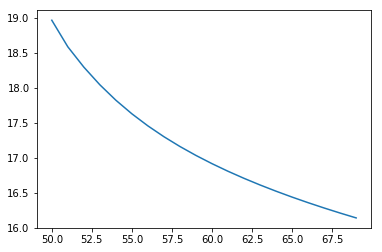

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

#plot how cost values changes
plt.plot([np.mean(cost_values[i-50:i]) for i in range(len(cost_values))])
plt.show()